In [18]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Carica il dataset
df = pd.read_csv('only_one_language_country.csv')

# Seleziona le colonne rilevanti
columns_to_keep = [
    'genre', 'duration_df1', 'language', 'country', 'converted_budget', 
    'dir_oscar_nomination', 'dir_oscar_won', 'writer_oscar_nomination', 
    'writer_oscar_won', 'cast_oscar_nomination', 'cast_oscar_won', 
    'dir_globe_nomination', 'dir_globe_won', 'production_company_df1',
    'cast_globe_nomination', 'cast_globe_won', 'revenue_with_CPI'
]

df_selected = df[columns_to_keep].dropna()
# Visualizza le prime righe del dataset selezionato
print(df_selected.head())



                 genre  duration_df1 language country  converted_budget  \
0         Crime, Drama          88.0  English     USA          175700.3   
1                Drama          59.0  English     USA         3013850.0   
2  Drama, History, War          77.0  English     USA          521727.6   
3                Drama          50.0  English     USA         5598468.6   
4     Adventure, Crime         300.0   French  France        10802441.1   

   dir_oscar_nomination  dir_oscar_won  writer_oscar_nomination  \
0                     0              0                        0   
1                     0              0                        0   
2                     0              0                        0   
3                     0              0                        0   
4                     0              0                        0   

   writer_oscar_won  cast_oscar_nomination  cast_oscar_won  \
0                 0                      0               0   
1                 0   

In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np

# Funzione per one-hot encoding su colonne con valori multipli separati da virgole
def multi_value_one_hot(df, column):
    s = df[column].str.get_dummies(sep=',')
    return df.join(s.add_prefix(column + '_'))

# Applica one-hot encoding alle colonne 'genre', 'language', 'country' e 'production_company_df1'
df_selected = multi_value_one_hot(df_selected, 'genre')
df_selected = multi_value_one_hot(df_selected, 'language')
df_selected = multi_value_one_hot(df_selected, 'country')
df_selected = multi_value_one_hot(df_selected, 'production_company_df1')

# Rimuovi le colonne originali 'genre', 'language', 'country' e 'production_company_df1'
df_selected.drop(columns=['genre', 'language', 'country', 'production_company_df1'], inplace=True)

# Rimuovi righe con NaN nella colonna 'converted_budget'
df_selected = df_selected.dropna(subset=['converted_budget'])

# Converti tutte le colonne in numeriche
df_selected = df_selected.apply(pd.to_numeric, errors='coerce')

# Crea fasce di guadagno con intervalli specificati
bins = [0, 100000000, 500000000, np.inf]  # Specifica i tuoi bin qui
labels = ['0-100,000,000', '100,000,000-500,000,000', '500,000,000+']  # Etichette per i bin
df_selected['revenue_range'] = pd.cut(df_selected['revenue_with_CPI'], bins=bins, labels=labels, right=False)

# Rimuovi la colonna originale 'revenue_with_CPI'
df_selected.drop(columns=['revenue_with_CPI'], inplace=True)

# Definisci le feature e il target
X = df_selected.drop(columns=['revenue_range'])
y = df_selected['revenue_range']

# Standardizza le feature
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Dividi i dati in train e test set
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Crea il modello Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Allena il modello
rf_classifier.fit(X_train, y_train)

# Fai previsioni sui dati di test
y_pred_test = rf_classifier.predict(X_test)

# Fai previsioni sui dati di train
y_pred_train = rf_classifier.predict(X_train)

# Calcola le metriche di valutazione per il test set
accuracy_test = accuracy_score(y_test, y_pred_test)
report_test = classification_report(y_test, y_pred_test)
conf_matrix_test = confusion_matrix(y_test, y_pred_test)

# Calcola le metriche di valutazione per il train set
accuracy_train = accuracy_score(y_train, y_pred_train)
report_train = classification_report(y_train, y_pred_train)
conf_matrix_train = confusion_matrix(y_train, y_pred_train)

print(f'Test Set - Accuracy: {accuracy_test}')
print(f'Test Set - Classification Report:\n{report_test}')
print(f'Test Set - Confusion Matrix:\n{conf_matrix_test}')

print(f'\nTrain Set - Accuracy: {accuracy_train}')
print(f'Train Set - Classification Report:\n{report_train}')
print(f'Train Set - Confusion Matrix:\n{conf_matrix_train}')

# Visualizza le prime righe del dataset risultante per verifica
print(df_selected.head())


Test Set - Accuracy: 0.8131386861313868
Test Set - Classification Report:
                         precision    recall  f1-score   support

          0-100,000,000       0.86      0.95      0.90      3221
100,000,000-500,000,000       0.50      0.33      0.40       704
           500,000,000+       0.59      0.30      0.39       185

               accuracy                           0.81      4110
              macro avg       0.65      0.53      0.57      4110
           weighted avg       0.79      0.81      0.79      4110

Test Set - Confusion Matrix:
[[3052  156   13]
 [ 443  235   26]
 [  53   77   55]]

Train Set - Accuracy: 1.0
Train Set - Classification Report:
                         precision    recall  f1-score   support

          0-100,000,000       1.00      1.00      1.00     12782
100,000,000-500,000,000       1.00      1.00      1.00      2884
           500,000,000+       1.00      1.00      1.00       774

               accuracy                           1.00     1

In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTENC
import numpy as np

# Funzione per one-hot encoding su colonne con valori multipli separati da virgole
def multi_value_one_hot(df, column):
    s = df[column].str.get_dummies(sep=',')
    return df.join(s.add_prefix(column + '_'))

# Carica il dataset
df = pd.read_csv('only_one_language_country.csv')

# Seleziona le colonne rilevanti
columns_to_keep = [
    'genre', 'duration_df1', 'language', 'country', 'converted_budget', 
    'dir_oscar_nomination', 'dir_oscar_won', 'writer_oscar_nomination', 
    'writer_oscar_won', 'cast_oscar_nomination', 'cast_oscar_won', 
    'dir_globe_nomination', 'dir_globe_won', 'production_company_df1',
    'cast_globe_nomination', 'cast_globe_won', 'revenue_with_CPI'
]

df_selected = df[columns_to_keep].dropna()

# Applica one-hot encoding alle colonne 'genre', 'language', 'country' e 'production_company_df1'
df_selected = multi_value_one_hot(df_selected, 'genre')
df_selected = multi_value_one_hot(df_selected, 'language')
df_selected = multi_value_one_hot(df_selected, 'country')
df_selected = multi_value_one_hot(df_selected, 'production_company_df1')

# Rimuovi le colonne originali 'genre', 'language', 'country' e 'production_company_df1'
df_selected.drop(columns=['genre', 'language', 'country', 'production_company_df1'], inplace=True)

# Rimuovi righe con NaN nella colonna 'converted_budget'
df_selected = df_selected.dropna(subset=['converted_budget'])

# Converti tutte le colonne in numeriche
df_selected = df_selected.apply(pd.to_numeric, errors='coerce')

# Crea fasce di guadagno con intervalli specificati
bins = [0, 100000000, 500000000, np.inf]  # Specifica i tuoi bin qui
labels = ['0-100,000,000', '100,000,000-500,000,000', '500,000,000+']  # Etichette per i bin
df_selected['revenue_range'] = pd.cut(df_selected['revenue_with_CPI'], bins=bins, labels=labels, right=False)


# Rimuovi la colonna originale 'revenue_with_CPI'
df_selected.drop(columns=['revenue_with_CPI'], inplace=True)

# Definisci le feature e il target
X = df_selected.drop(columns=['revenue_range'])
y = df_selected['revenue_range']

# Dividi i dati in train e test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Identifica le colonne categoriche
categorical_features = [i for i, col in enumerate(X_train.columns) if col.startswith(('genre_', 'language_', 'country_', 'production_company_df1_'))]

# Applica SMOTENC solo sui dati di training
smote_nc = SMOTENC(categorical_features=categorical_features, random_state=42)
X_train_resampled, y_train_resampled = smote_nc.fit_resample(X_train, y_train)


# Standardizza le feature
scaler = StandardScaler()
X_train_resampled_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# Crea il modello Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Allena il modello
rf_classifier.fit(X_train_resampled_scaled, y_train_resampled)

# Fai previsioni sui dati di test
y_pred_test = rf_classifier.predict(X_test_scaled)

# Fai previsioni sui dati di train
y_pred_train = rf_classifier.predict(X_train_resampled_scaled)

# Calcola le metriche di valutazione per il test set
accuracy_test = accuracy_score(y_test, y_pred_test)
report_test = classification_report(y_test, y_pred_test)
conf_matrix_test = confusion_matrix(y_test, y_pred_test)

# Calcola le metriche di valutazione per il train set
accuracy_train = accuracy_score(y_train_resampled, y_pred_train)
report_train = classification_report(y_train_resampled, y_pred_train)
conf_matrix_train = confusion_matrix(y_train_resampled, y_pred_train)

print(f'Test Set - Accuracy: {accuracy_test}')
print(f'Test Set - Classification Report:\n{report_test}')
print(f'Test Set - Confusion Matrix:\n{conf_matrix_test}')

print(f'\nTrain Set - Accuracy: {accuracy_train}')
print(f'Train Set - Classification Report:\n{report_train}')
print(f'Train Set - Confusion Matrix:\n{conf_matrix_train}')

# Visualizza le prime righe del dataset risultante per verifica
print(pd.DataFrame(X_train_resampled).head())
print(y_train_resampled.head())


Dimensioni del dataset resampled:
revenue_range
0-100,000,000              774
100,000,000-500,000,000    774
500,000,000+               774
Name: count, dtype: int64
Test Set - Accuracy: 0.7160583941605839
Test Set - Classification Report:
                         precision    recall  f1-score   support

          0-100,000,000       0.94      0.75      0.84      3221
100,000,000-500,000,000       0.35      0.54      0.42       704
           500,000,000+       0.31      0.75      0.44       185

               accuracy                           0.72      4110
              macro avg       0.53      0.68      0.57      4110
           weighted avg       0.81      0.72      0.75      4110

Test Set - Confusion Matrix:
[[2428  667  126]
 [ 148  377  179]
 [  10   37  138]]

Train Set - Accuracy: 1.0
Train Set - Classification Report:
                         precision    recall  f1-score   support

          0-100,000,000       1.00      1.00      1.00       774
100,000,000-500,000,000 

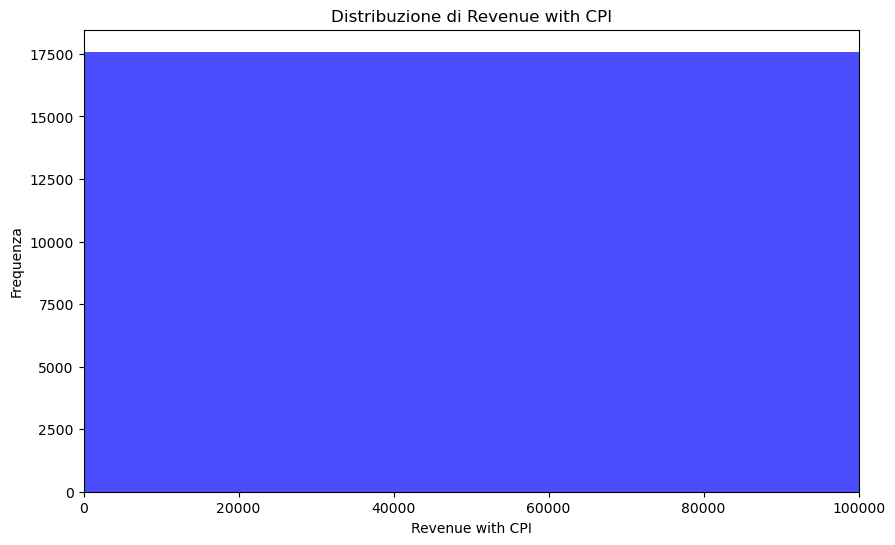

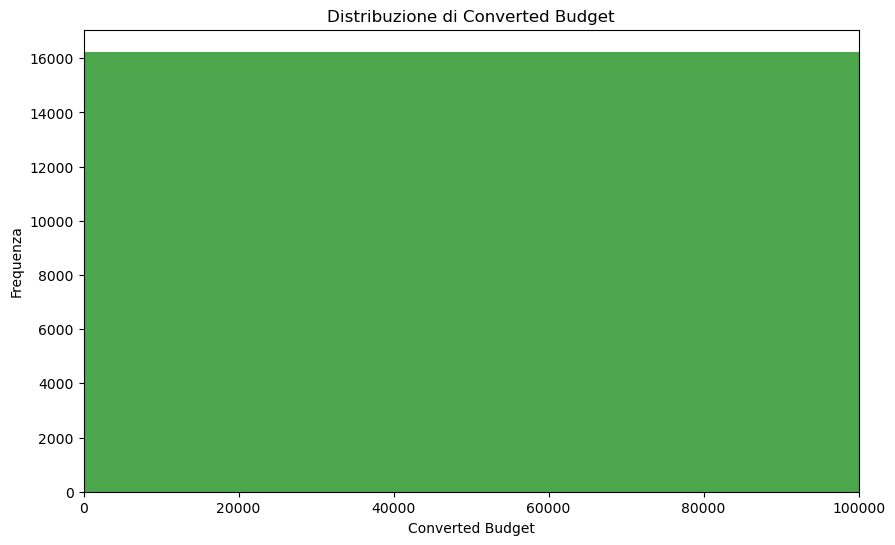

In [17]:
import matplotlib.pyplot as plt

# Visualizza la distribuzione di 'revenue_with_CPI'
# Visualizza la distribuzione di 'revenue_with_CPI' con asse x limitato
plt.figure(figsize=(10, 6))
plt.hist(df_selected['revenue_with_CPI'], bins=50, color='blue', alpha=0.7)
plt.title('Distribuzione di Revenue with CPI')
plt.xlabel('Revenue with CPI')
plt.ylabel('Frequenza')
plt.xlim(left=0, right=1000000000)  
plt.show()

# Visualizza la distribuzione di 'converted_budget'
plt.figure(figsize=(10, 6))
plt.hist(df_selected['converted_budget'], bins=50, color='green', alpha=0.7)
plt.title('Distribuzione di Converted Budget')
plt.xlabel('Converted Budget')
plt.ylabel('Frequenza')
plt.xlim(left=0, right=1000000000) 
plt.show()

In [3]:
#10-fold-stratified-cross validation
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTENC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np

# Inizializza lo StratifiedKFold
skf = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)

# Liste per memorizzare i risultati di ogni fold
test_accuracies = []
test_reports = []
test_conf_matrices = []

train_accuracies = []
train_reports = []
train_conf_matrices = []

# Identifica le colonne categoriche
categorical_features = [i for i, col in enumerate(X.columns) if col.startswith(('genre_', 'language_', 'country_', 'production_company_df1_'))]

# Loop attraverso ogni fold
for train_index, test_index in skf.split(X, y):
    X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

    # Applica SMOTENC solo sui dati di training
    smote_nc = SMOTENC(categorical_features=categorical_features, random_state=42)
    X_train_resampled, y_train_resampled = smote_nc.fit_resample(X_train_fold, y_train_fold)

    # Standardizza le feature
    scaler = StandardScaler()
    X_train_resampled_scaled = scaler.fit_transform(X_train_resampled)
    X_test_scaled = scaler.transform(X_test_fold)

    # Allena il modello
    rf_classifier.fit(X_train_resampled_scaled, y_train_resampled)

    # Fai previsioni sui dati di test
    y_pred_test = rf_classifier.predict(X_test_scaled)
    y_pred_train = rf_classifier.predict(X_train_resampled_scaled)

    # Calcola le metriche di valutazione per il test set
    accuracy_test = accuracy_score(y_test_fold, y_pred_test)
    report_test = classification_report(y_test_fold, y_pred_test)
    conf_matrix_test = confusion_matrix(y_test_fold, y_pred_test)

    # Calcola le metriche di valutazione per il train set
    accuracy_train = accuracy_score(y_train_resampled, y_pred_train)
    report_train = classification_report(y_train_resampled, y_pred_train)
    conf_matrix_train = confusion_matrix(y_train_resampled, y_pred_train)

    # Salva i risultati
    test_accuracies.append(accuracy_test)
    test_reports.append(report_test)
    test_conf_matrices.append(conf_matrix_test)

    train_accuracies.append(accuracy_train)
    train_reports.append(report_train)
    train_conf_matrices.append(conf_matrix_train)

# Calcola le metriche medie
mean_test_accuracy = np.mean(test_accuracies)
mean_test_conf_matrix = np.mean(test_conf_matrices, axis=0)

mean_train_accuracy = np.mean(train_accuracies)
mean_train_conf_matrix = np.mean(train_conf_matrices, axis=0)

print(f'Mean Test Accuracy: {mean_test_accuracy}')
print(f'Mean Test Confusion Matrix:\n{mean_test_conf_matrix}')

print(f'\nMean Train Accuracy: {mean_train_accuracy}')
print(f'Mean Train Confusion Matrix:\n{mean_train_conf_matrix}')

# Visualizza i report di classificazione per ogni fold (opzionale)
for i, (train_report, test_report) in enumerate(zip(train_reports, test_reports)):
    print(f'Fold {i+1} - Train Classification Report:\n{train_report}')
    print(f'Fold {i+1} - Test Classification Report:\n{test_report}')


Mean Test Accuracy: 0.7921654501216545
Mean Test Confusion Matrix:
[[1445.7  142.1   12.5]
 [ 188.2  147.2   23.4]
 [  20.8   40.1   35. ]]

Mean Train Accuracy: 0.9999861136826365
Mean Train Confusion Matrix:
[[1.44026e+04 0.00000e+00 1.00000e-01]
 [4.00000e-01 1.44023e+04 0.00000e+00]
 [1.00000e-01 0.00000e+00 1.44026e+04]]
Fold 1 - Train Classification Report:
                         precision    recall  f1-score   support

          0-100,000,000       1.00      1.00      1.00     14402
100,000,000-500,000,000       1.00      1.00      1.00     14402
           500,000,000+       1.00      1.00      1.00     14402

               accuracy                           1.00     43206
              macro avg       1.00      1.00      1.00     43206
           weighted avg       1.00      1.00      1.00     43206

Fold 1 - Test Classification Report:
                         precision    recall  f1-score   support

          0-100,000,000       0.88      0.90      0.89      1601
100,000,